## 1. Data loading and exploration

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
# Import countries polygons
fp = os.path.join('data','ne_50m_admin_0_countries','ne_50m_admin_0_countries.shp')
countries = gpd.read_file(fp)

# Simplify column names
countries.columns = countries.columns.str.lower()

# Select columns fo analysis
countries = countries[['admin', 'type', 'geometry']]
countries.head(3)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."


In [7]:
df = gpd.read_file("data/arctic_communities.geojson")
df.head()

,admin,country,n_communities,geometry
0,United States of America,US,115,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576..."
1,United Kingdom,GB,96,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51..."
2,Sweden,SE,133,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57..."
3,Russia,RU,774,"MULTIPOLYGON (((145.88154 43.45952, 145.89561 ..."
4,Norway,NO,48,"MULTIPOLYGON (((20.62217 69.03687, 20.49199 69..."


## 2. Check Geometry Types

In [15]:
# Define a function to inspect geometry types of features in GeoDataFrame

def check_polygons(gdf):
    geom_types = gdf.geom_type.unique()
    if len(geom_types) > 1:
        print("Multiple feature types:", geom_types)
    else:
        print("All features are:", geom_types[0])
        
check_polygons(df)

Multiple feature types: ['MultiPolygon' 'Polygon']


## 3. Explode Polygons

The .explode() method takes multipolygons and separates them into individual polygons (multiple single geometries).

**Parameters:**

`ignore_index`
bool, default False
If True, the resulting index will be labelled 0, 1, …, n - 1, ignoring index_parts.

`index_parts`
boolean, default False
If True, the resulting index will be a multi-index (original index with an additional level indicating the multiple geometries: a new zero-based index for each single part geometry per multi-part geometry).

In [18]:
# "Exploding" our data frame avoiding the multi-part index, and resetting index to run from 1 through n again
df = df.explode(index_parts = False).reset_index()

In [19]:
# Checking that exploding words with our new function
check_polygons(df)

All features are: Polygon


## 4. Compute minimum y-coordinate for polygons

In [21]:
# Select first row of df
df.iloc[1] # it is an object

type(df.iloc[1])

pandas.core.series.Series

In [29]:
row = df.iloc[0]

print(type(row.geometry))

# print the bounds of the polygon (xmin, ymin, xmax, ymax) 
print(row.geometry.bounds)

<class 'shapely.geometry.polygon.Polygon'>
(-132.948046875, 56.511035156249996, -132.56796875, 56.794775390625)


In [31]:
row.geometry.bounds[1]

56.511035156249996

In [32]:
def min_y(row):
    return row.geometry.bounds[1]

# Applying it to the entire data frame
df["miny"] = df.apply(min_y, axis = 1)

In [34]:
# Selecting for just minimum y that is = or greater than 40
arctic = df[df['miny'] >= 40]

# Convert to different CRS (the one with north pole at the center)
arctic = arctic.to_crs(epsg = 3413)

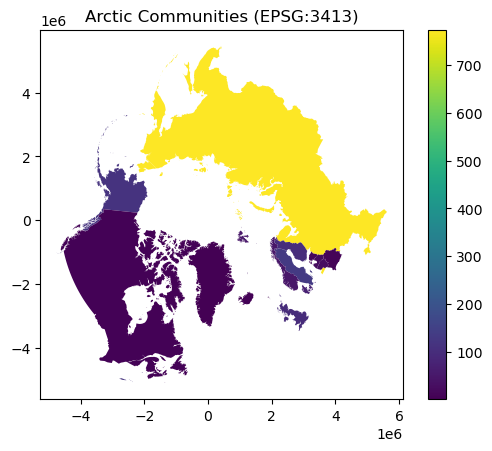

In [40]:
arctic.plot(column = "n_communities",
           legend = True)

plt.title("Arctic Communities (EPSG:3413)")
plt.show()

In [37]:
arctic

,index,admin,country,n_communities,geometry,miny
0,0,United States of America,US,115,"POLYGON ((-3725925.296 -146595.535, -3727676.3...",56.511035
1,0,United States of America,US,115,"POLYGON ((-3758791.596 -145719.927, -3759288.2...",56.244141
2,0,United States of America,US,115,"POLYGON ((-3528847.709 -42330.126, -3531749.22...",58.204102
3,0,United States of America,US,115,"POLYGON ((-3233070.801 576975.062, -3235532.75...",60.312646
4,0,United States of America,US,115,"POLYGON ((-3297700.143 555729.359, -3297892.33...",59.812646
...,...,...,...,...,...,...
476,13,Canada,CA,7,"POLYGON ((-2172496.999 -1051797.986, -2171487....",67.878809
477,13,Canada,CA,7,"POLYGON ((-2250394.448 -1142049.590, -2248665....",66.857812
478,13,Canada,CA,7,"POLYGON ((-2174506.546 -1045437.698, -2175524....",67.987598
479,13,Canada,CA,7,"POLYGON ((-2229596.170 157594.622, -2233555.75...",69.539307
